In [150]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupShuffleSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.base import BaseEstimator, ClassifierMixin
from collections import defaultdict
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import shap
from sklearn.inspection import permutation_importance
from pandas.plotting import table

In [152]:
# Import data
df_gait = pd.read_csv('gait.csv')

# Pivot the dataframe to make the 'time' values become columns
df = df_gait.pivot_table(
    index=['subject', 'condition', 'replication', 'leg', 'joint'],
    columns='time', 
    values='angle'
)

df.reset_index(inplace=True)

df.columns = ['subject', 'condition', 'replication', 'leg', 'joint'] + [f'time_{int(col)}' for col in df.columns[5:]]

# Add the 'brace' feature based on the 'condition' column
df['brace'] = df['condition'].apply(lambda x: 0 if x == 1 else 1)

df.to_csv('transformed_gait_data.csv', index=False)

print(df.shape)
print(df.head())

(1800, 107)
   subject  condition  replication  leg  joint     time_0     time_1  \
0        1          1            1    1      1   4.682881   5.073127   
1        1          1            1    1      2   3.693683   4.258876   
2        1          1            1    1      3  16.607868  16.851029   
3        1          1            1    2      1   5.015829   5.291201   
4        1          1            1    2      2   2.244425   3.381678   

      time_2     time_3     time_4  ...    time_92    time_93    time_94  \
0   5.229774   5.083273   4.652399  ...   8.725667   7.628732   6.736811   
1   5.346945   6.769831   8.351716  ...  25.253682  20.560889  15.960689   
2  17.170098  17.504693  17.806602  ...  20.821052  20.216791  19.485746   
3   5.410528   5.270628   4.814143  ...   5.369366   4.895390   4.556679   
4   4.925566   6.623978   8.268602  ...  22.453507  18.454504  14.513444   

     time_95    time_96    time_97    time_98    time_99   time_100  brace  
0   6.152976   5.9130

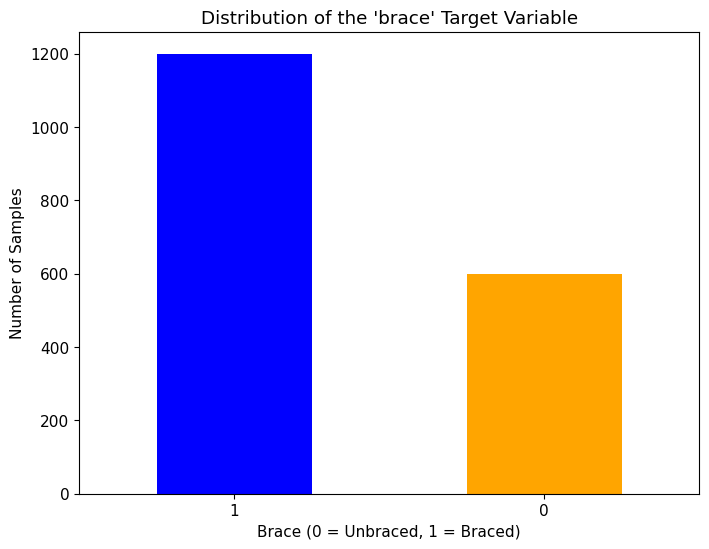

In [154]:
# Check the distribution of the target variable

brace_counts = df['brace'].value_counts()

# Plot the distribution
plt.figure(figsize=(8, 6))
brace_counts.plot(kind='bar', color=['blue', 'orange'])
plt.title("Distribution of the 'brace' Target Variable")
plt.xlabel("Brace (0 = Unbraced, 1 = Braced)")
plt.ylabel("Number of Samples")
plt.xticks(rotation=0)
plt.savefig("figures/EDA_1.png", dpi=300, bbox_inches="tight")
plt.show()

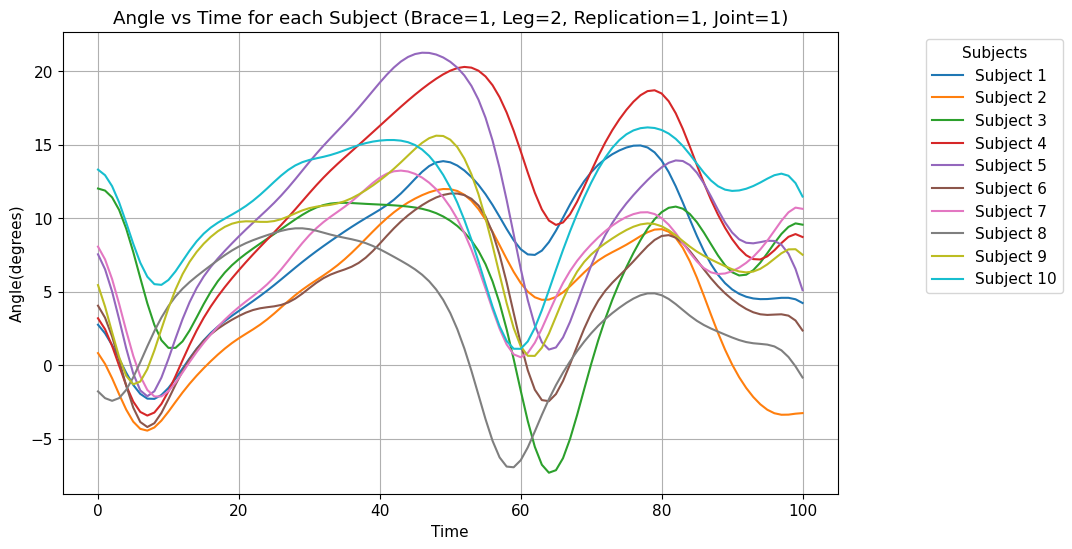

In [156]:
filtered_df = df[(df['brace'] == 1) & 
                       (df['leg'] == 2) & 
                       (df['replication'] == 1) & 
                       (df['joint'] == 1)]
filtered_df = filtered_df.drop_duplicates(subset=['subject'])
plt.figure(figsize=(10, 6))

time_points = [f'time_{i}' for i in range(101)]

for index, row in filtered_df.iterrows():
    plt.plot(range(101), row[time_points], label=f'Subject {int(row["subject"])}')

plt.xlabel('Time')
plt.ylabel('Angle(degrees)')
plt.title('Angle vs Time for each Subject (Brace=1, Leg=2, Replication=1, Joint=1)')
plt.legend(title="Subjects", loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid()
plt.savefig("figures/EDA_2.png", dpi=300, bbox_inches="tight")
plt.show()

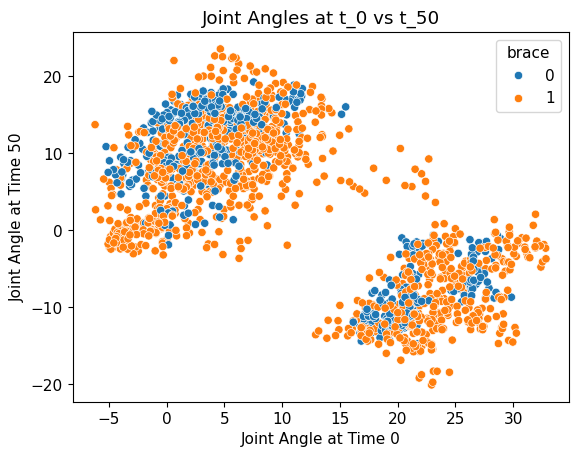

In [157]:
sns.scatterplot(x='time_0', y='time_50', hue='brace', data=df)
plt.title('Joint Angles at t_0 vs t_50')
plt.xlabel('Joint Angle at Time 0')
plt.ylabel('Joint Angle at Time 50')
plt.savefig("figures/EDA_3.png", dpi=300, bbox_inches="tight")
plt.show()

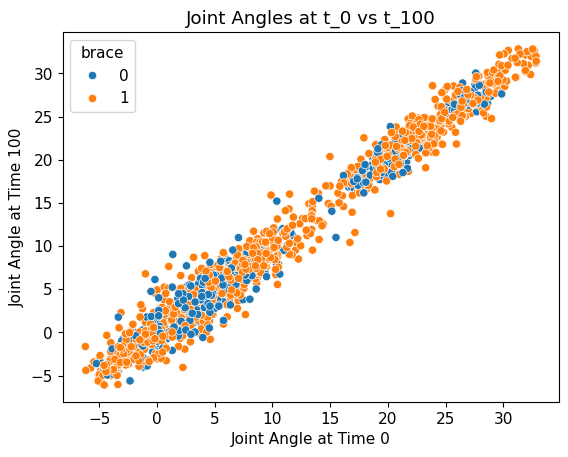

In [159]:
sns.scatterplot(x='time_0', y='time_100', hue='brace', data=df)
plt.title('Joint Angles at t_0 vs t_100')
plt.xlabel('Joint Angle at Time 0')
plt.ylabel('Joint Angle at Time 100')
plt.savefig("figures/EDA_4.png", dpi=300, bbox_inches="tight")
plt.show()

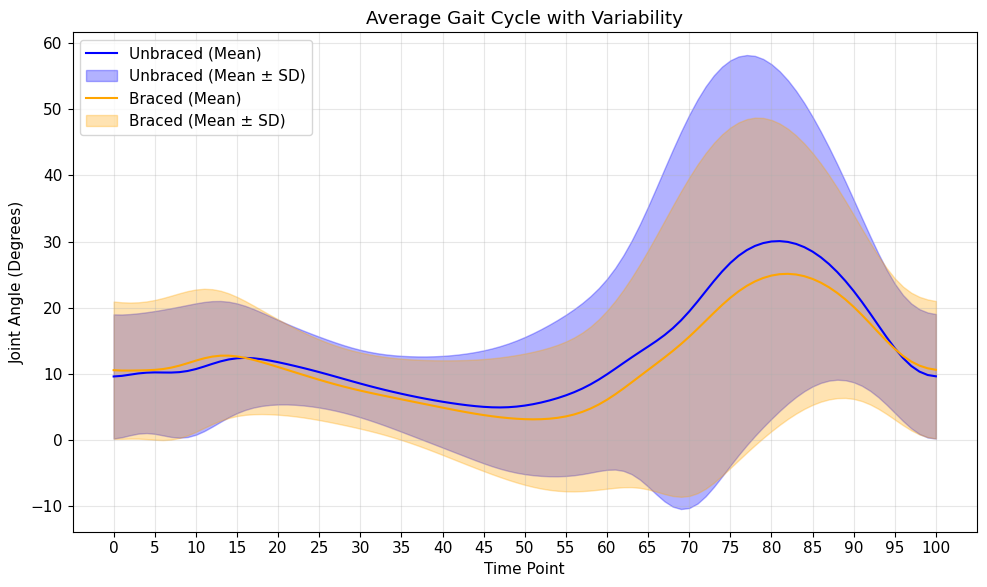

In [162]:
# Assuming 'df' is your dataframe
time_points = [f'time_{i}' for i in range(101)]

# Group data by 'brace' and calculate mean and standard deviation
grouped = df.groupby('brace')[time_points]
mean_angles = grouped.mean().T
std_angles = grouped.std().T

# Create the plot
plt.figure(figsize=(10, 6))

# Plot mean and shaded area for unbraced (brace=0)
plt.plot(mean_angles.index, mean_angles[0], label='Unbraced (Mean)', color='blue')
plt.fill_between(mean_angles.index, 
                 mean_angles[0] - std_angles[0], 
                 mean_angles[0] + std_angles[0], 
                 color='blue', alpha=0.3, label='Unbraced (Mean ± SD)')

# Plot mean and shaded area for braced (brace=1)
plt.plot(mean_angles.index, mean_angles[1], label='Braced (Mean)', color='orange')
plt.fill_between(mean_angles.index, 
                 mean_angles[1] - std_angles[1], 
                 mean_angles[1] + std_angles[1], 
                 color='orange', alpha=0.3, label='Braced (Mean ± SD)')

# Modify x-axis to show fewer ticks
plt.xticks(range(0, 101, 5), [f'{i}' for i in range(0, 101, 5)])  # Show every 10th time point

plt.title('Average Gait Cycle with Variability')
plt.xlabel('Time Point')
plt.ylabel('Joint Angle (Degrees)')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("figures/EDA_5.png", dpi=300, bbox_inches="tight")
plt.show()


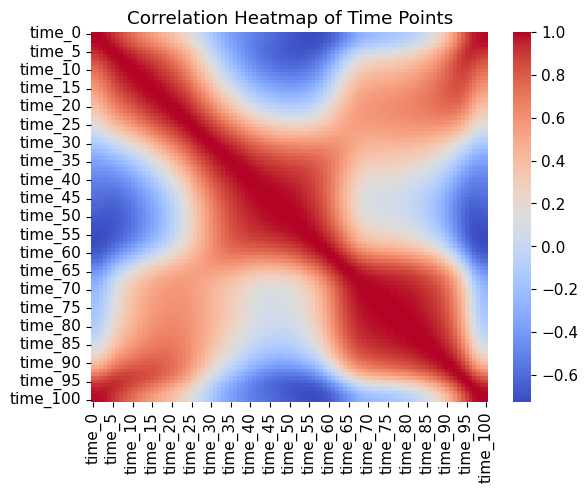

In [164]:
corr = df[time_points].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Time Points')
plt.savefig("figures/EDA_6.png", dpi=300, bbox_inches="tight")
plt.show()

In [166]:
# Create the feature matrix X, and target variable y
y = df['brace']
X = df.drop(columns=['brace', 'condition'])
groups = df['subject']

# Define feature groups
onehot_ftrs = ['subject', 'replication', 'leg', 'joint']
std_ftrs = [col for col in X.columns if col.startswith('t')]

# Collect all the encoders into one preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), onehot_ftrs),
        ('std', StandardScaler(), std_ftrs)
    ])

# Create a preprocessing pipeline
prep = Pipeline(steps=[('preprocessor', preprocessor)])

In [168]:
# Hyperparameters

param_grid = {
    'LogisticRegression': {
        'penalty': ['l1', 'l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'max_iter': [8000]  
    },
    'RandomForestClassifier': {
        'max_depth': [1, 3, 10, 30, 100],
        'max_features': [0.25, 0.5, 0.75, 1.0]
    },
    'XGBClassifier': {
        "n_estimators": [10000],
        'max_depth': [1, 3, 10, 30, 100],
        'reg_alpha': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
        'reg_lambda': [0e0, 1e-2, 1e-1, 1e0, 1e1, 1e2],
        'colsample_bytree': [0.8],
        'subsample': [0.6]   
    },
    'SVC': {
        'C': [0.1, 1, 10, 100, 1000],
        'gamma': [0.001, 0.01, 0.1, 1, 10, 100]
    }
}

In [170]:
# Define models
models = {
    'LogisticRegression': LogisticRegression(random_state=None, solver='saga'),
    'RandomForestClassifier': RandomForestClassifier(random_state=None),
    'XGBClassifier': XGBClassifier(random_state=None, eval_metric='logloss', early_stopping_rounds=50), 
    'SVC': SVC(random_state=None)
}

In [174]:
# Define random states
random_states = [0, 2, 4, 8, 42]

# Dictionary to store results
results = []

# Loop through each random state
for random_state in random_states:
    print(f"Evaluating for random state: {random_state}")

    # Initialize GroupShuffleSplit for train-test split
    gss_test_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_val_idx, test_idx = next(gss_test_split.split(X, y, groups))

    # Create train-validation and test sets
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
    groups_train_val = groups.iloc[train_val_idx]

    # Initialize GroupShuffleSplit for train-validation split
    gss_val_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, val_idx = next(gss_val_split.split(X_train_val, y_train_val, groups_train_val))

    # Create train and validation sets
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    # Print the unique subjects in each set
    print("Training subjects:", groups_train_val.iloc[train_idx].unique())
    print("Validation subjects:", groups_train_val.iloc[val_idx].unique())
    print("Test subjects:", groups.iloc[test_idx].unique())

    # Fit the preprocessor on the training set and transform all sets
    X_train_preprocessed = prep.fit_transform(X_train)
    X_val_preprocessed = prep.transform(X_val)
    X_test_preprocessed = prep.transform(X_test)
    
    for model_name, model in models.items():
        print(f"Training {model_name}...")
        
        # Update the random state for the model
        if model_name in ['LogisticRegression', 'RandomForestClassifier', 'SVC', 'XGBClassifier']:
            model.set_params(random_state=random_state)
        
        # Set up GridSearchCV
        grid = GridSearchCV(estimator=model, param_grid=param_grid[model_name], scoring='accuracy', cv=5, n_jobs=-1)
        
        # Handle early stopping for XGBClassifier
        if model_name == 'XGBClassifier':
            grid.fit(
                X_train_preprocessed, y_train,
                eval_set=[(X_val_preprocessed, y_val)],
                verbose=False
            )
        else:
            grid.fit(X_train_preprocessed, y_train)
        
        # Get the best parameters and validation score
        best_params = grid.best_params_
        best_val_score = grid.best_score_
        
        # Store the results
        results.append({
            'random_state': random_state,
            'model': model_name,
            'best_params': best_params,
            'validation_score': best_val_score
        })

Evaluating for random state: 0
Training subjects: [ 1  2  5  6  7 10]
Validation subjects: [4 8]
Test subjects: [3 9]
Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training SVC...
Evaluating for random state: 2
Training subjects: [ 1  4  6  8  9 10]
Validation subjects: [3 7]
Test subjects: [2 5]
Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training SVC...
Evaluating for random state: 4
Training subjects: [1 2 3 5 7 8]
Validation subjects: [ 6 10]
Test subjects: [4 9]
Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training SVC...
Evaluating for random state: 8
Training subjects: [2 3 4 5 6 8]
Validation subjects: [ 1 10]
Test subjects: [7 9]
Training LogisticRegression...
Training RandomForestClassifier...
Training XGBClassifier...
Training SVC...
Evaluating for random state: 42
Training subjects: [ 1  4  5  6  8 10]
Validation subjects: [3 7]
Test s

AttributeError: 'list' object has no attribute 'to_csv'

In [176]:
results_df = pd.DataFrame(results, columns=['random_state', 'model', 'best_params', 'validation_score'])
results_df.to_csv('results/model_training.csv', index=False)
# Print all results for 20 models
print("\nSummary of Best Models and Hyperparameters:")
for result in results:
    print(f"Random State: {result['random_state']}")
    print(f"Model: {result['model']}")
    print(f"  Best Hyperparameters: {result['best_params']}")
    print(f"  Validation Score: {result['validation_score']:.4f}")


Summary of Best Models and Hyperparameters:
Random State: 0
Model: LogisticRegression
  Best Hyperparameters: {'C': 1, 'max_iter': 8000, 'penalty': 'l1'}
  Validation Score: 0.8324
Random State: 0
Model: RandomForestClassifier
  Best Hyperparameters: {'max_depth': 10, 'max_features': 0.25}
  Validation Score: 0.8269
Random State: 0
Model: XGBClassifier
  Best Hyperparameters: {'colsample_bytree': 0.8, 'max_depth': 10, 'n_estimators': 10000, 'reg_alpha': 0.1, 'reg_lambda': 0.1, 'subsample': 0.6}
  Validation Score: 0.7500
Random State: 0
Model: SVC
  Best Hyperparameters: {'C': 100, 'gamma': 0.1}
  Validation Score: 0.8667
Random State: 2
Model: LogisticRegression
  Best Hyperparameters: {'C': 1, 'max_iter': 8000, 'penalty': 'l1'}
  Validation Score: 0.7898
Random State: 2
Model: RandomForestClassifier
  Best Hyperparameters: {'max_depth': 30, 'max_features': 0.75}
  Validation Score: 0.8213
Random State: 2
Model: XGBClassifier
  Best Hyperparameters: {'colsample_bytree': 0.8, 'max_dep

In [178]:
# Apply models on test_set

# List to store test set results for all models
test_set_results = []

# Loop through the 20 models
for result in results:

    random_state = result['random_state']
    model_name = result['model']
    best_params = result['best_params']

    # Initialize GroupShuffleSplit for train-test split
    gss_test_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_val_idx, test_idx = next(gss_test_split.split(X, y, groups))

    # Create train-validation and test sets
    X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
    y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
    groups_train_val = groups.iloc[train_val_idx]

    # Initialize GroupShuffleSplit for train-validation split
    gss_val_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
    train_idx, val_idx = next(gss_val_split.split(X_train_val, y_train_val, groups_train_val))

    # Create train and validation sets
    X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
    y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

    # Fit the preprocessor on the training set and transform all sets
    X_train_preprocessed = prep.fit_transform(X_train)
    X_val_preprocessed = prep.transform(X_val)
    X_test_preprocessed = prep.transform(X_test)

    # Reinitialize the model with the best hyperparameters
    if model_name == 'LogisticRegression':
        model = LogisticRegression(**best_params, random_state=random_state, solver='saga')
    elif model_name == 'RandomForestClassifier':
        model = RandomForestClassifier(**best_params, random_state=random_state)
    elif model_name == 'XGBClassifier':
        model = XGBClassifier(**best_params, random_state=random_state, eval_metric='logloss')
    elif model_name == 'SVC':
        model = SVC(**best_params, random_state=random_state)

    # Fit the model on the train-validation set
    model.fit(X_train_preprocessed, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test_preprocessed)

    # Calculate performance metrics
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_f1 = f1_score(y_test, y_test_pred, average='binary')

    # Store the results
    test_set_results.append({
        'random_state': random_state,
        'model': model_name,
        'test_accuracy': test_accuracy,
        'test_f1_score': test_f1
    })

test_result_df = pd.DataFrame(test_set_results, columns=['random_state', 'model', 'test_accuracy', 'test_f1_score'])
test_result_df.to_csv('results/test_result_df.csv', index=False)
# Print the test set results for each model and random state
print("\nTest Set Performance for Each Model (Separated by Random State):")
for test_result in test_set_results:
    print(f"Random State: {test_result['random_state']}, Model: {test_result['model']}")
    print(f"  Test Accuracy: {test_result['test_accuracy']:.4f}")
    print(f"  Test F1 Score: {test_result['test_f1_score']:.4f}")



Test Set Performance for Each Model (Separated by Random State):
Random State: 0, Model: LogisticRegression
  Test Accuracy: 0.7222
  Test F1 Score: 0.7630
Random State: 0, Model: RandomForestClassifier
  Test Accuracy: 0.6861
  Test F1 Score: 0.7621
Random State: 0, Model: XGBClassifier
  Test Accuracy: 0.6667
  Test F1 Score: 0.7436
Random State: 0, Model: SVC
  Test Accuracy: 0.7028
  Test F1 Score: 0.7838
Random State: 2, Model: LogisticRegression
  Test Accuracy: 0.8389
  Test F1 Score: 0.8858
Random State: 2, Model: RandomForestClassifier
  Test Accuracy: 0.7167
  Test F1 Score: 0.8083
Random State: 2, Model: XGBClassifier
  Test Accuracy: 0.7722
  Test F1 Score: 0.8423
Random State: 2, Model: SVC
  Test Accuracy: 0.7472
  Test F1 Score: 0.8372
Random State: 4, Model: LogisticRegression
  Test Accuracy: 0.6528
  Test F1 Score: 0.6684
Random State: 4, Model: RandomForestClassifier
  Test Accuracy: 0.7194
  Test F1 Score: 0.7960
Random State: 4, Model: XGBClassifier
  Test Accurac

In [124]:
# Show combined results

# Collect test scores for each ML algorithm
test_algorithm_results = defaultdict(list)
test_algorithm_f1 = defaultdict(list)

# Organize test scores by algorithm
for test_result in test_set_results:
    test_algorithm_results[test_result['model']].append(test_result['test_accuracy'])
for test_result in test_set_results:
    test_algorithm_f1[test_result['model']].append(test_result['test_f1_score'])

# Calculate mean and standard deviation for test scores of each algorithm
test_mean_std_results = {}
for algorithm, scores in test_algorithm_results.items():
    mean_test_score = np.mean(scores)
    std_test_score = np.std(scores)
    test_mean_std_results[algorithm] = {'mean': mean_test_score, 'std': std_test_score}

test_mean_std_f1 = {}
for algorithm, scores in test_algorithm_f1.items():
    mean_test_score = np.mean(scores)
    std_test_score = np.std(scores)
    test_algorithm_f1[algorithm] = {'mean': mean_test_score, 'std': std_test_score}

# Print the mean and standard deviation of test scores
print("\nMean and Standard Deviation of Test Scores for Each Algorithm:")
for algorithm, stats in test_mean_std_results.items():
    print(f"{algorithm}:")
    print(f"  Mean Test Score: {stats['mean']:.4f}")
    print(f"  Standard Deviation: {stats['std']:.4f}")

print("\nMean and Standard Deviation of f1 for Each Algorithm:")
for algorithm, stats in test_algorithm_f1.items():
    print(f"{algorithm}:")
    print(f"  Mean Test Score: {stats['mean']:.4f}")
    print(f"  Standard Deviation: {stats['std']:.4f}")



Mean and Standard Deviation of Test Scores for Each Algorithm:
LogisticRegression:
  Mean Test Score: 0.7456
  Standard Deviation: 0.0613
RandomForestClassifier:
  Mean Test Score: 0.7172
  Standard Deviation: 0.0320
XGBClassifier:
  Mean Test Score: 0.7272
  Standard Deviation: 0.0498
SVC:
  Mean Test Score: 0.7711
  Standard Deviation: 0.0604

Mean and Standard Deviation of f1 for Each Algorithm:
LogisticRegression:
  Mean Test Score: 0.7847
  Standard Deviation: 0.0716
RandomForestClassifier:
  Mean Test Score: 0.7945
  Standard Deviation: 0.0279
XGBClassifier:
  Mean Test Score: 0.8000
  Standard Deviation: 0.0412
SVC:
  Mean Test Score: 0.8376
  Standard Deviation: 0.0428


In [126]:
# Calculate Baseline

# Get the majority class
majority_class = y.value_counts().idxmax()

# Create baseline predictions (predicting the majority class for all instances)
baseline_predictions = np.full_like(y, fill_value=majority_class)

# Calculate baseline accuracy
baseline_accuracy = accuracy_score(y, baseline_predictions)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

# Define the beta value for F-beta score (e.g., 1 for F1 score)
beta = 1

# Calculate baseline F-beta score
baseline_fbeta = fbeta_score(y, baseline_predictions, beta=beta, average='binary', pos_label=majority_class)
print(f"Baseline F-beta Score (β={beta}): {baseline_fbeta:.4f}")

Baseline Accuracy: 0.6667
Baseline F-beta Score (β=1): 0.8000


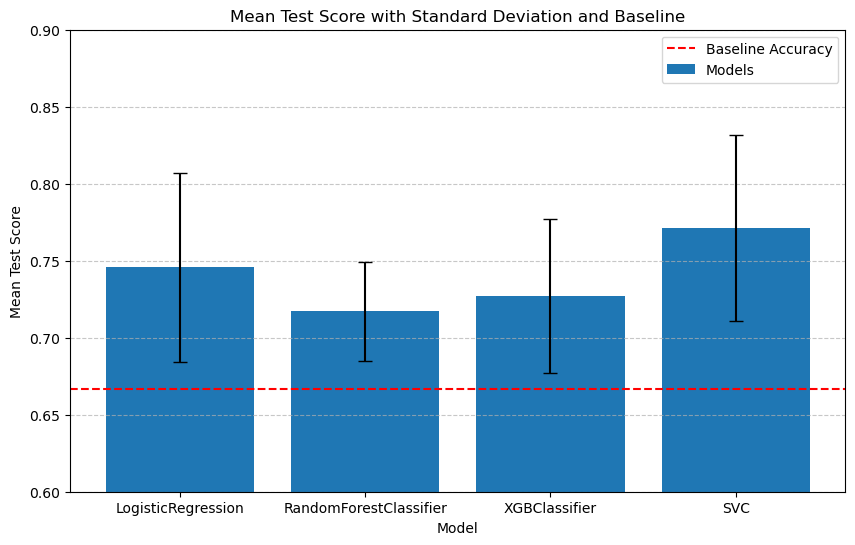

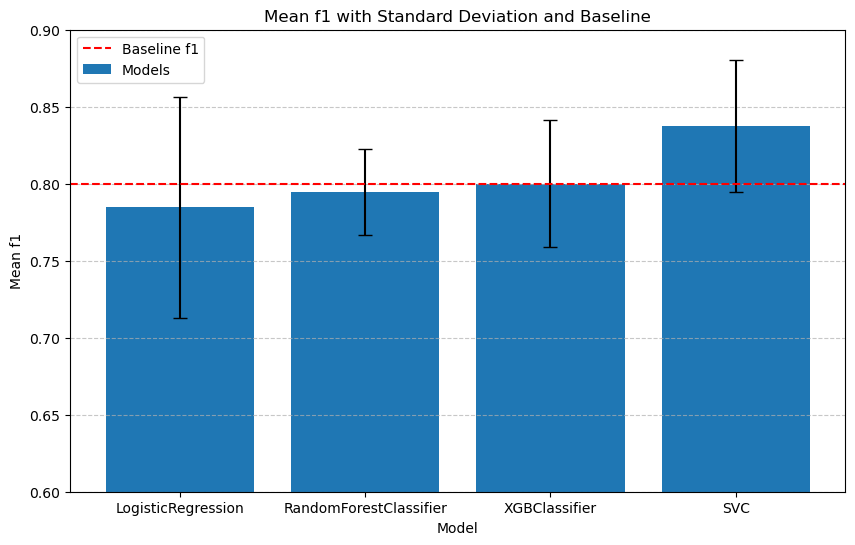

In [91]:
# Performance of ML model compare with baseline

summary_data = {
    'Model': ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'SVC'],
    'Mean Test Score': [0.7456, 0.7172, 0.7272, 0.7711],
    'Std Test Score': [0.0613, 0.0320, 0.0498, 0.0604], 
    'Mean f1': [0.7847, 0.7945, 0.8000, 0.8376],
    'Std f1': [0.0716, 0.0279, 0.0412, 0.0428]
}

# Create a DataFrame for the results
summary_df = pd.DataFrame(summary_data)

baseline_accuracy = 0.6667
baseline_f1 = 0.800

# Plot the results with baseline
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Model'], summary_df['Mean Test Score'], yerr=summary_df['Std Test Score'], capsize=5, label='Models')
plt.axhline(y=baseline_accuracy, color='red', linestyle='--', label='Baseline Accuracy')

# Title and labels
plt.title('Mean Test Score with Standard Deviation and Baseline')
plt.ylabel('Mean Test Score')
plt.xlabel('Model')
plt.ylim(0.6, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.savefig("figures/result_2.png", dpi=300)
plt.show()

# Plot the f1 with baseline
plt.figure(figsize=(10, 6))
plt.bar(summary_df['Model'], summary_df['Mean f1'], yerr=summary_df['Std f1'], capsize=5, label='Models')
plt.axhline(y=baseline_f1, color='red', linestyle='--', label='Baseline f1')

# Title and labels
plt.title('Mean f1 with Standard Deviation and Baseline')
plt.ylabel('Mean f1')
plt.xlabel('Model')
plt.ylim(0.6, 0.9)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.savefig("figures/result_3.png", dpi=300)
plt.show()

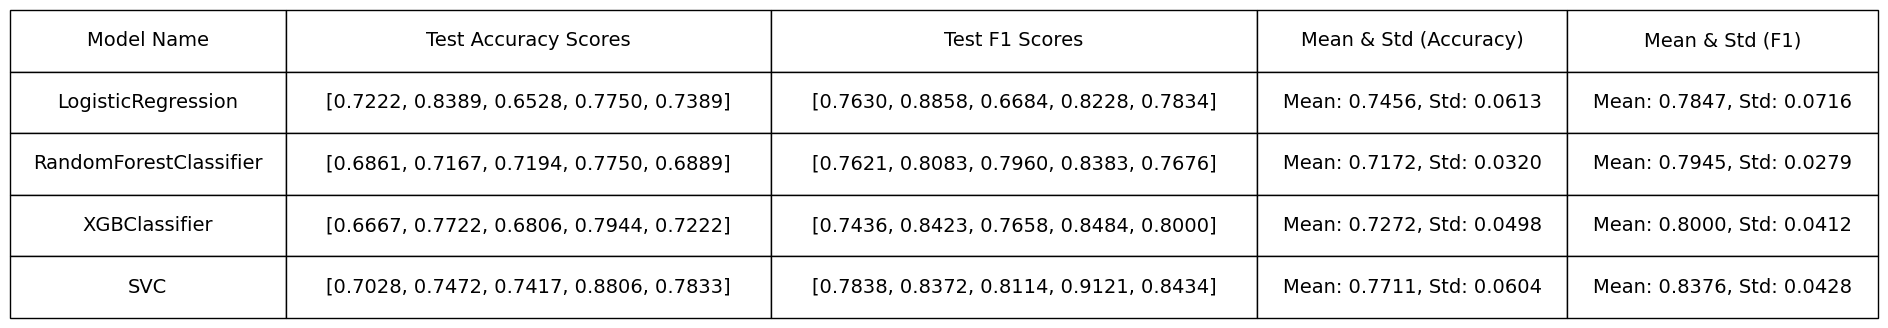

In [85]:
test_scores_data = {
    'Model Name': ['LogisticRegression', 'RandomForestClassifier', 'XGBClassifier', 'SVC'],
    'Test Accuracy Scores': [
        '[0.7222, 0.8389, 0.6528, 0.7750, 0.7389]',  # LogisticRegression
        '[0.6861, 0.7167, 0.7194, 0.7750, 0.6889]',  # RandomForestClassifier
        '[0.6667, 0.7722, 0.6806, 0.7944, 0.7222]',  # XGBClassifier
        '[0.7028, 0.7472, 0.7417, 0.8806, 0.7833]'   # SVC
    ],
    'Test F1 Scores': [
        '[0.7630, 0.8858, 0.6684, 0.8228, 0.7834]',  # LogisticRegression
        '[0.7621, 0.8083, 0.7960, 0.8383, 0.7676]',  # RandomForestClassifier
        '[0.7436, 0.8423, 0.7658, 0.8484, 0.8000]',  # XGBClassifier
        '[0.7838, 0.8372, 0.8114, 0.9121, 0.8434]'   # SVC
    ],
    'Mean & Std (Accuracy)': [
        'Mean: 0.7456, Std: 0.0613',  # LogisticRegression
        'Mean: 0.7172, Std: 0.0320',  # RandomForestClassifier
        'Mean: 0.7272, Std: 0.0498',  # XGBClassifier
        'Mean: 0.7711, Std: 0.0604'   # SVC
    ],
    'Mean & Std (F1)': [
        'Mean: 0.7847, Std: 0.0716',  # LogisticRegression
        'Mean: 0.7945, Std: 0.0279',  # RandomForestClassifier
        'Mean: 0.8000, Std: 0.0412',  # XGBClassifier
        'Mean: 0.8376, Std: 0.0428'   # SVC
    ]
}

# Create a DataFrame for the table
test_scores_df = pd.DataFrame(test_scores_data)

# Create a plot with a table
fig, ax = plt.subplots(figsize=(8, 4))  # Adjust figure size
ax.axis("off")  # Turn off the plot axes

# Add the table
table = ax.table(
    cellText=test_scores_df.values,
    colLabels=test_scores_df.columns,
    cellLoc="center",
    loc="center",
)

# Adjust row height
for key, cell in table.get_celld().items():
    cell.set_height(0.2)  # Adjust this value for taller rows

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width(col=list(range(len(df.columns))))

# Save the table as a plot
plt.savefig("figures/result_1.png", dpi=300, bbox_inches="tight")
plt.show()

In [95]:
random_state = 8
best_params = {
    "LogisticRegression": {"penalty": "l1", "C": 1, "max_iter": 8000},
    "RandomForestClassifier": {"max_depth": 10, "max_features": 0.5},
    "XGBClassifier": {"max_depth": 10, "reg_alpha": 1.0, "reg_lambda": 0.1, "subsample": 0.6, "colsample_bytree": 0.8, "n_estimators": 10000},
    "SVC": {"C": 1000, "gamma": 0.01}
}
# Initialize GroupShuffleSplit for train-test split
gss_test_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
train_val_idx, test_idx = next(gss_test_split.split(X, y, groups))

# Create train-validation and test sets
X_train_val, X_test = X.iloc[train_val_idx], X.iloc[test_idx]
y_train_val, y_test = y.iloc[train_val_idx], y.iloc[test_idx]
groups_train_val = groups.iloc[train_val_idx]

# Initialize GroupShuffleSplit for train-validation split
gss_val_split = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=random_state)
train_idx, val_idx = next(gss_val_split.split(X_train_val, y_train_val, groups_train_val))

# Create train and validation sets
X_train, X_val = X_train_val.iloc[train_idx], X_train_val.iloc[val_idx]
y_train, y_val = y_train_val.iloc[train_idx], y_train_val.iloc[val_idx]

# Fit the preprocessor on the training set and transform all sets
X_train_preprocessed = prep.fit_transform(X_train)
X_val_preprocessed = prep.transform(X_val)
X_test_preprocessed = prep.transform(X_test)

In [97]:
# Logistic Regression
logistic_regression_model = LogisticRegression(**best_params["LogisticRegression"], random_state=random_state, solver='saga')
logistic_regression_model.fit(X_train_preprocessed, y_train)

# Random Forest
random_forest_model = RandomForestClassifier(**best_params["RandomForestClassifier"], random_state=random_state)
random_forest_model.fit(X_train_preprocessed, y_train)

# XGBoost
xgb_model = XGBClassifier(**best_params["XGBClassifier"], eval_metric='logloss', random_state=random_state, early_stopping_rounds=50)
xgb_model.fit(X_train_preprocessed, y_train, eval_set=[(X_val_preprocessed, y_val)], verbose=False)

# SVC
svc_model = SVC(**best_params["SVC"], random_state=random_state)
svc_model.fit(X_train_preprocessed, y_train)

SVC(C=1000, gamma=0.01, random_state=8)

In [98]:
# Predictions
logistic_regression_predictions = logistic_regression_model.predict(X_test_preprocessed)
random_forest_predictions = random_forest_model.predict(X_test_preprocessed)
xgb_predictions = xgb_model.predict(X_test_preprocessed)
svc_predictions = svc_model.predict(X_test_preprocessed)

# Organize predictions
model_predictions = {
    "LogisticRegression": logistic_regression_predictions,
    "RandomForestClassifier": random_forest_predictions,
    "XGBClassifier": xgb_predictions,
    "SVC": svc_predictions
}

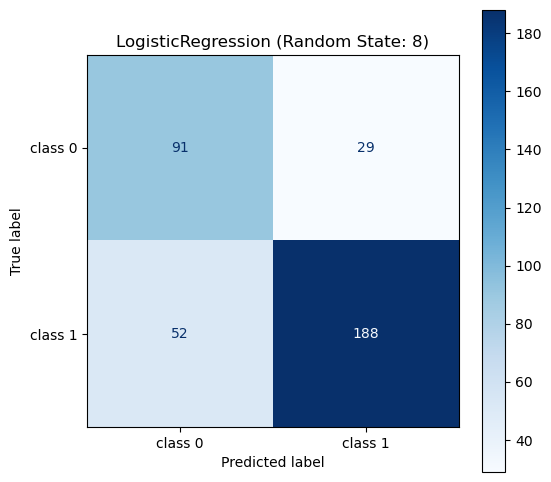

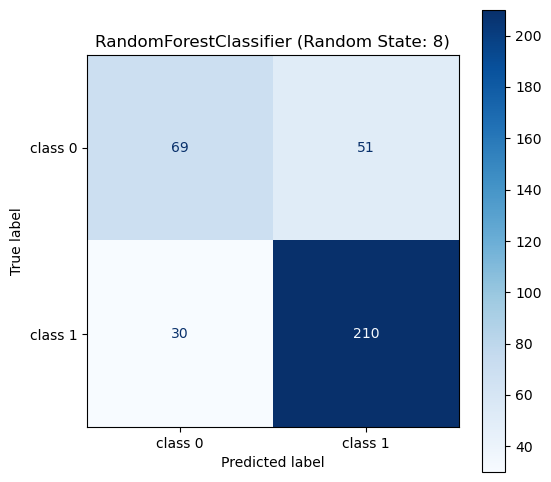

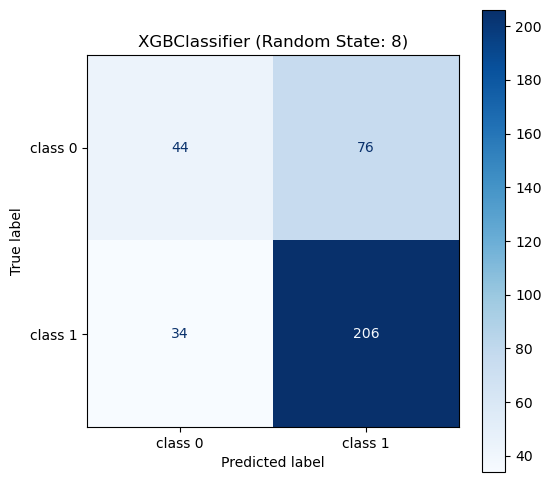

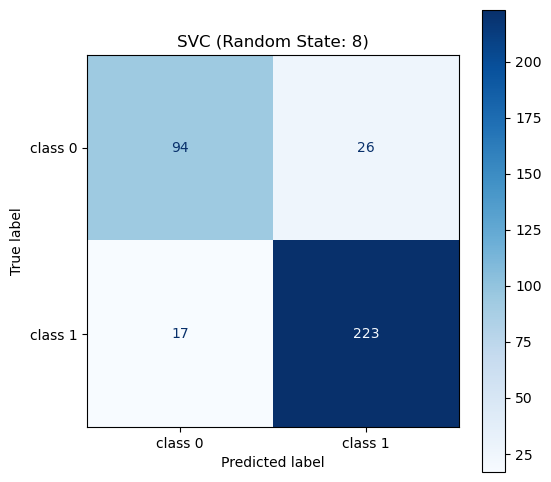

In [103]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

# Use the true labels from the test set
true_labels = y_test

# Plot confusion matrices
for model_name, predictions in model_predictions.items():
    # Compute confusion matrix without normalization (counts)
    cm = confusion_matrix(true_labels, predictions)  # Remove `normalize='true'` for raw counts

    plt.figure(figsize=(6, 6))
    
    # Display confusion matrix with counts
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["class 0", "class 1"])
    disp.plot(cmap="Blues", values_format="d", ax=plt.gca())  # `values_format="d"` ensures counts are shown

    plt.title(f"{model_name} (Random State: 8)")
    plt.savefig(f"{model_name}_conf_matrix.png", dpi=300, bbox_inches="tight")
    plt.show()


Baseline Test Score: 0.8805555555555555


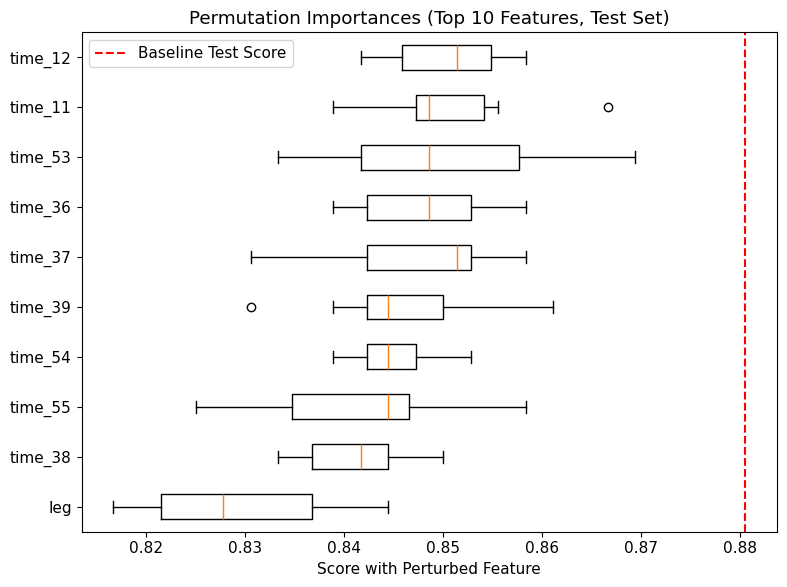

In [105]:
# Global 1

nr_runs = 10  # Number of perturbation runs per feature
scores = np.zeros([len(X_test.columns), nr_runs])  # Array to store accuracy scores
ftr_names = X_test.columns  # Feature names

# Calculate baseline test score
test_score = svc_model.score(X_test_preprocessed, y_test)
print('Baseline Test Score:', test_score)

# Perturbation loop
for i, feature in enumerate(ftr_names):
    for j in range(nr_runs):
        # Shuffle the feature
        X_test_shuffled = X_test.copy()
        X_test_shuffled[feature] = np.random.permutation(X_test[feature].values)
        
        # Score the model with shuffled feature
        perturbed_score = svc_model.score(prep.transform(X_test_shuffled), y_test)
        scores[i, j] = perturbed_score

# Find the 10 most important features based on the mean accuracy scores
top_10_indices = np.argsort(np.mean(scores, axis=1))[:10]  # Smallest mean indicates most impact when perturbed
top_10_features = ftr_names[top_10_indices]

# Plot the box plot for the top 10 features
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(8, 6))
plt.boxplot(scores[top_10_indices].T, vert=False, tick_labels=top_10_features)
plt.axvline(test_score, color='red', linestyle='--', label='Baseline Test Score')
plt.title("Permutation Importances (Top 10 Features, Test Set)")
plt.xlabel("Score with Perturbed Feature")
plt.legend()
plt.tight_layout()
plt.savefig("figures/global_1.png", dpi=300, bbox_inches="tight")
plt.show()

In [115]:
# Global 2

# Reduce the size of the background data and test set
background_data = X_train_preprocessed[:10]

# KernelExplainer with reduced background data
explainer = shap.KernelExplainer(svc_model.decision_function, background_data)
shap_values = explainer.shap_values(X_test_preprocessed)

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [07:48<00:00,  1.30s/it]


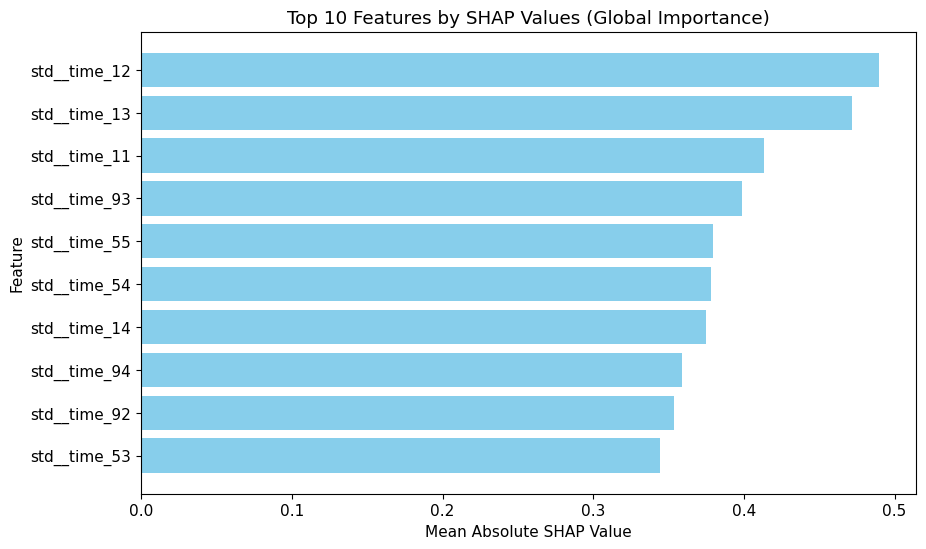

In [119]:
if hasattr(prep, "get_feature_names_out"):
    feature_names = prep.get_feature_names_out()
else:
    feature_names = ["Feature_" + str(i) for i in range(X_test_preprocessed.shape[1])]

# Calculate global importance (mean absolute SHAP values)
shap_importance = pd.DataFrame({
    "Feature": feature_names,  # Replace with feature names if not already
    "Mean Absolute SHAP Value": np.abs(shap_values).mean(axis=0)
})
shap_importance = shap_importance.sort_values(by="Mean Absolute SHAP Value", ascending=False)

# Plot the top 10 features
top_10_shap = shap_importance.head(10)
plt.figure(figsize=(10, 6))
plt.barh(top_10_shap["Feature"], top_10_shap["Mean Absolute SHAP Value"], color="skyblue")
plt.xlabel("Mean Absolute SHAP Value")
plt.ylabel("Feature")
plt.title("Top 10 Features by SHAP Values (Global Importance)")
plt.gca().invert_yaxis()
plt.tight_layout
plt.savefig("figures/global_2.png", dpi=300, bbox_inches="tight")
plt.show()

Top 10 Features based on Logistic Regression Coefficients:
               Feature  Importance
20     onehot__joint_3   11.882533
19     onehot__joint_2    8.460448
27         std__time_6    3.094229
26         std__time_5    2.925081
32        std__time_11    2.869666
33        std__time_12    2.816312
2    onehot__subject_4    2.710093
21         std__time_0    2.620438
119       std__time_98    1.852209
75        std__time_54    1.846006


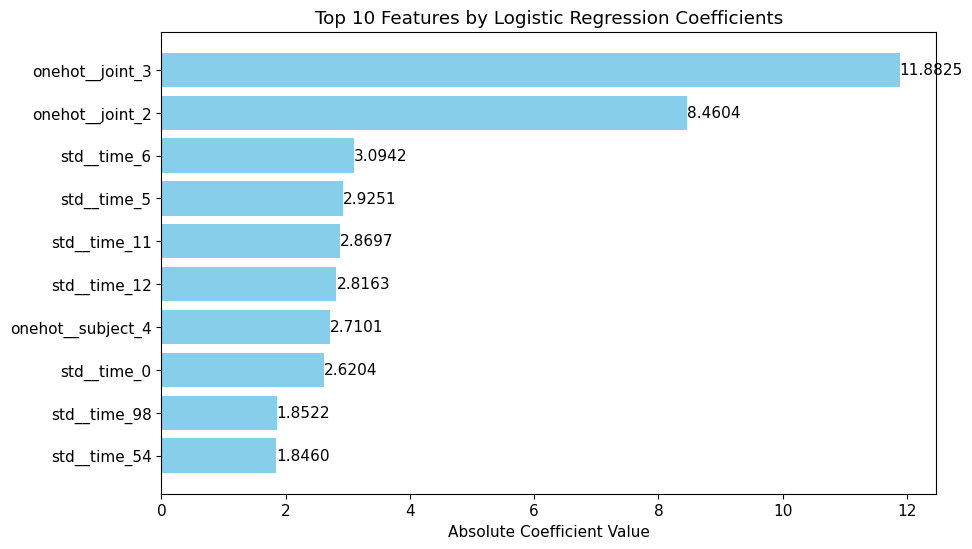

In [147]:
# global 3

logistic_regression_model.fit(X_train_preprocessed, y_train)


categorical_features = ['leg', 'joint', 'subject', 'replication']
numerical_features = [f'time_{i}' for i in range(101)] 

# Extract feature names

all_feature_names = prep.get_feature_names_out()

# Get the absolute coefficients and sort them
coefficients = logistic_regression_model.coef_[0]
feature_importance = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': np.abs(coefficients)
}).sort_values(by='Importance', ascending=False)

# Display the top 10 most important features
print("Top 10 Features based on Logistic Regression Coefficients:")
print(feature_importance.head(10))

# Plot the feature importance

plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(feature_importance['Feature'][:10], feature_importance['Importance'][:10], color='skyblue')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.title('Top 10 Features by Logistic Regression Coefficients')
plt.xlabel('Absolute Coefficient Value')
for index, value in enumerate(top_features['Importance']):
    plt.text(value, index, f'{value:.4f}', va='center')
plt.savefig("figures/global_3.png", dpi=300, bbox_inches="tight")
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [03:16<00:00,  1.83it/s]


Data Point: 0


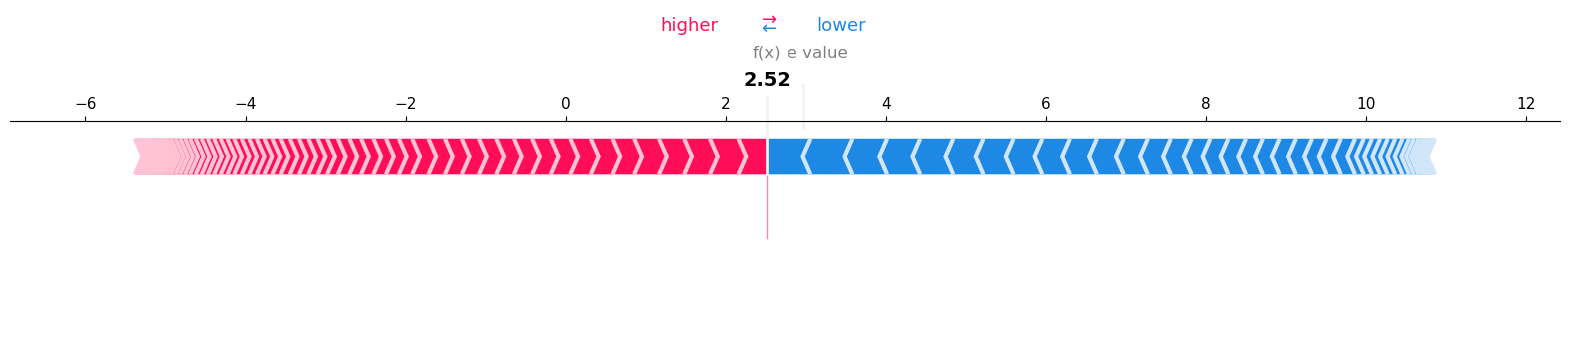

Data Point: 100


<Figure size 640x480 with 0 Axes>

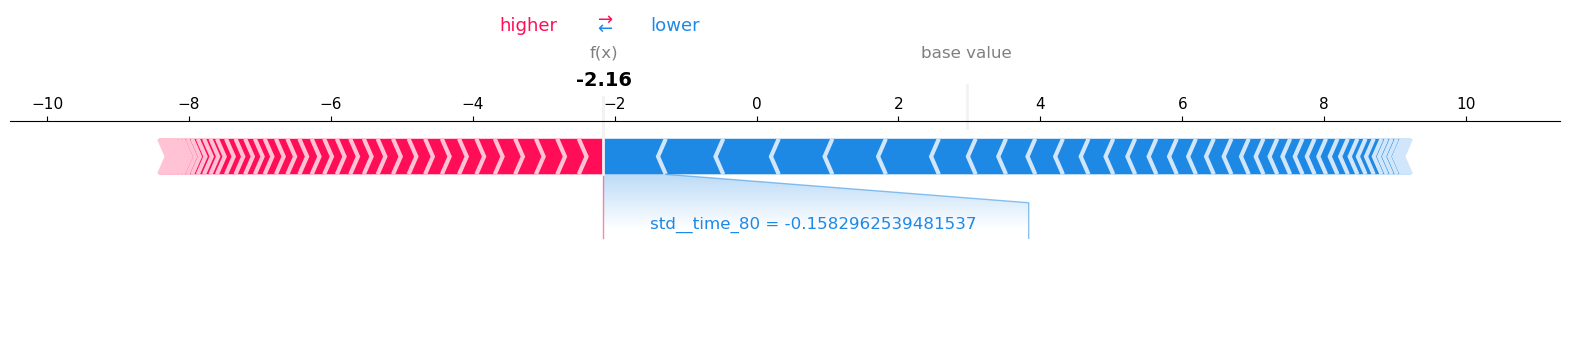

Data Point: 200


<Figure size 640x480 with 0 Axes>

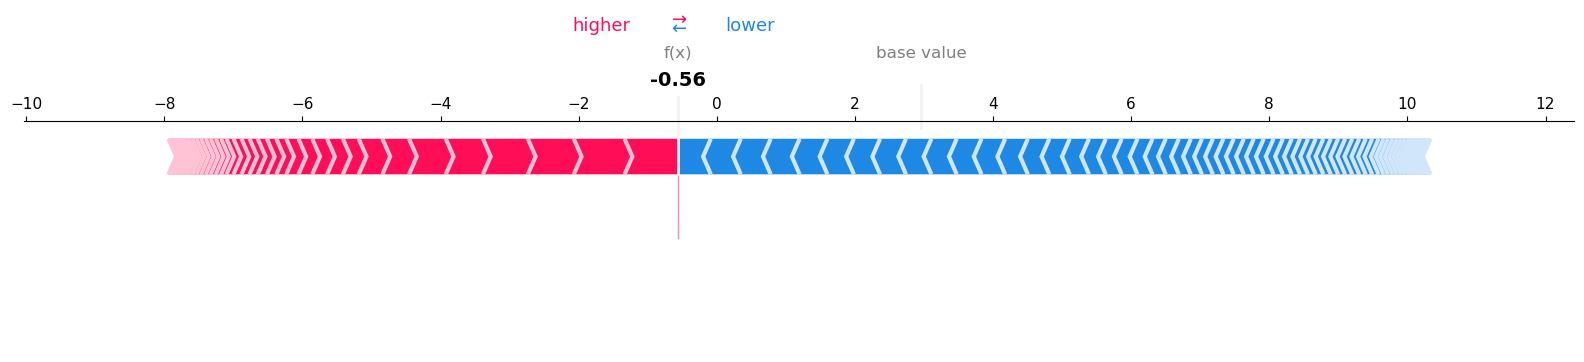

<Figure size 640x480 with 0 Axes>

In [321]:
# Select the data points by indices
indices = [0, 100, 200]
feature_names = prep.get_feature_names_out()  # Extract feature names from the preprocessing pipeline
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=feature_names)

# Now you can use iloc
selected_data = X_test_preprocessed_df.iloc[indices]

# Create the SHAP KernelExplainer for the SVC model
explainer = shap.KernelExplainer(svc_model.decision_function, selected_data[:100])
shap_values = explainer.shap_values(X_test_preprocessed_df)
import shap
shap.initjs()  # Initialize SHAP visualization

# Generate force plots for the selected data points
for i, index in enumerate(indices):
    print(f"Data Point: {index}")
    shap.force_plot(
        explainer.expected_value,
        shap_values[i],
        selected_data.iloc[i],
        matplotlib=True  # Use Matplotlib for static plots
    )
    plt.savefig(f"force_plot_{index}.png", bbox_inches="tight")

In [319]:
plt.savefig(f"force_plot_{index}.png", bbox_inches="tight")

<Figure size 640x480 with 0 Axes>

In [ ]:
shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    selected_data.iloc[i],
    matplotlib=True
).savefig(f"force_plot_{index}.png", bbox_inches="tight")

In [325]:
for i, index in enumerate(indices):
    print(f"Data Point: {index}")
    # Save the force plot as an HTML file
    shap.save_html(f"force_plot_{index}.html", shap.force_plot(
    explainer.expected_value,
    shap_values[i],
    selected_data.iloc[i]
    ))


Data Point: 0
Data Point: 100
Data Point: 200
